In [16]:
# imports
import pandas as pd
import numpy as np
import config
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('dark')
sns.set_style('ticks')
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")


In [2]:
query = "select AID, SID, AC50, TOP, SLOPE, MSE from hill_models "

data = pd.read_sql_query(query, con=config.Config.DB_URI)

print(data.head())

   AID     SID       AC50         TOP     SLOPE           MSE
0  411  842150  57.698629  -95.606255  7.999998  7.892736e-09
1  411  842180  11.939105  -61.100214  7.988266  1.871814e-09
2  411  842209  57.681462  -81.881479  7.999998  5.816926e-09
3  411  842268  11.123286  -42.140094  7.916468  3.461023e-09
4  411  842291   2.617825 -105.899148  0.963853  5.957853e+00


How many unique AIDs?

In [3]:
data.AID.nunique()

3293

About 38% are missing?

In [4]:
data.isnull().any(1).sum() / data.shape[0]

0.004744942633160541

Whats the distribution of fit (MSE) values?

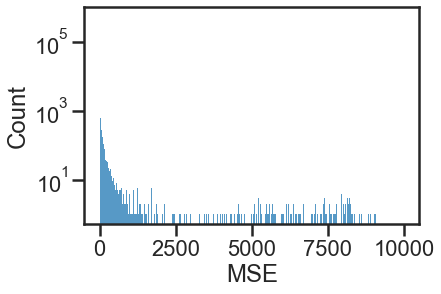

In [6]:
ax = sns.histplot(x=data.MSE)
ax.set_yscale('log')

Looking at some examples...

In [12]:
from curve_fitting import hill_curve

In [98]:
data_trim = data.query("TOP < 90").sort_values('MSE', ascending=False)
data_trim = data.copy().sort_values('MSE', ascending=False)
sample = data_trim.sample(1)

In [99]:
aid_target, sid_target = 1645841, 363678220
aid_target, sid_target = sample.AID.iloc[0], sample.SID.iloc[0]

query = "select AID, SID, Concentration, Response from dose_response WHERE AID == {} AND SID == {} ".format(aid_target, sid_target)

dr_data = pd.read_sql_query(query, con=config.Config.DB_URI)
dr_data['log(Concentration)'] = np.log10(dr_data.Concentration)
params = data.query(f"AID == {aid_target} & SID == {sid_target}")
params.head()

,AID,SID,AC50,TOP,SLOPE,MSE
252415,485349,26661481,12.415122,68.182139,7.963392,2.375751e-09


In [100]:
params

,AID,SID,AC50,TOP,SLOPE,MSE
252415,485349,26661481,12.415122,68.182139,7.963392,2.375751e-09


In [101]:
import numpy as np
xs = np.linspace(dr_data.Concentration.min(), dr_data.Concentration.max())


curve = hill_curve(xs, params.AC50.iloc[0], params.TOP.iloc[0], params.SLOPE.iloc[0])

In [102]:
from curvep import curveP

curveP_corrected = curveP(dr_data)

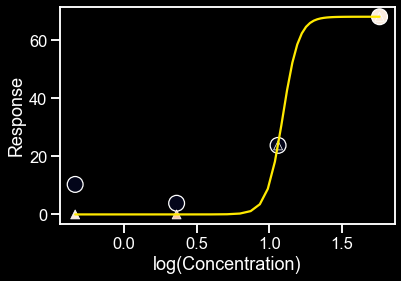

In [103]:
fig, ax = plt.subplots()
#ax.set(xscale="log")

sns.scatterplot(data=dr_data, x='log(Concentration)', y='Response', ax=ax, c=(0, 0, 0, 1), s=250)
sns.scatterplot(data=curveP_corrected, x='log(Concentration)', y='Response', ax=ax, c=(255/255, 233/255, 0, 1), marker='^')
sns.lineplot(x=np.log10(xs), y=curve, ax=ax, color=(255/255, 233/255, 0, 1))
plt.show()